In [1]:
# python version 3.11.3
import numpy as np # version 1.24.3
import matplotlib.pyplot as plt # version 3.7.1
from scipy.stats import norm # version 1.10.1

class FunctionalCausalModel:
    """
    Create an instance of the functional casual model defined by the following:
    A is a sinusoidal time series: A(t) = sin(t).
    C is a random processes modelled by Brownian motion: C(t + dt) = C(t) + N(0, delta**2 * dt; t, t+dt)
    B has a linear trend with respect to time, given by B(t) = B(t-1) + k + l*C(t). Where k and l are constants.
    O is given by O(t) = p*A(t) + q*(C(t))2 + m*B(t). Where p, q and m are constants.
    
    # Required input: 
    time array as linear spaced np.arrange
    
    # Optional args:
    * brownian_delta = 0.25,
    * B_t0 = 0,
    * k = 1,
    * l = 1,
    * p = 1,
    * q = 1,
    * m = 1
    
    
    # Attributes:
    A: observations of function A including noise
    B: observations of function B including noise
    C: observations of function C no noise
    O: observations of function O including noise
    
    
    """
    def __init__(
            self,
            time_range,
            brownian_delta = 0.25,
            B_t0 = 0,
            k = 1,
            l = 1,
            p = 1,
            q = 1,
            m = 1):
        self.t = time_range
        self.dt = self.t[1] - self.t[0]
        self.delta = brownian_delta
        self.B_t0 = B_t0
        self.k = k
        self.l = l
        self.p = p
        self.q = q
        self.m = m
        self.A_no_noise = self.create_A()
        self.C_no_noise = self.create_C()
        self.B_no_noise = self.create_B()
        self.O_no_noise = self.create_O()
        self.A = self.A_no_noise + self.add_noise()
        self.C = self.C_no_noise
        self.B = self.B_no_noise + self.add_noise()
        self.O = self.O_no_noise + self.add_noise()
        
    def create_A(self):
        return np.sin(self.t)
    
    def create_C(self):
        """
        A random processes modelled by Brownian motion.
        From https://scipy-cookbook.readthedocs.io/items/BrownianMotion.html
        Each interation is generated by a normally distributed random variable with mean 0 and
        variance delta**2 * dt
        C(t + dt) = C(t) + N(0, delta**2 * dt; t, t+dt)
        """
        x = 0.0 # Initial condition.
        n = len(self.t)
        values = np.zeros(n)
        # Iterate to compute the steps of the Brownian motion.
        for k in range(n):
            if k == 0:
                values[k] == x
            else:
                values[k] = values[k-1] + norm.rvs(scale=self.delta**2*self.dt)
        return values
        
    def create_B(self):
        """
        B(t) = B(t-1) + k + l*C(t),
        k and l are constants, 
        B(t=0) defined on initialisation using B_t0
        """
        B_out = np.zeros(len(self.t))
        for n,i in enumerate(self.t):
            if n == 0:
                B_out[0] = self.B_t0
            else:
                B_out[n] = B_out[n-1] + self.k + self.l*self.C_no_noise[n]
        return B_out
    
    def create_O(self):
        """
         O(t) = p*A(t) + q*(C(t))**2 + m*B(t),
         p, q, m are constants.
        """
        out = np.zeros(len(self.t))
        
        for n,i in enumerate(self.t):
            out[n] = self.p*self.A_no_noise[n] + self.q*self.C_no_noise[n]**2 + self.m*self.B_no_noise[n]
        return out
    
    def add_noise(self):
        n = len(self.t)
        noise = np.random.normal(0,0.1,n)
        return noise

In [2]:
def plot_model(model:FunctionalCausalModel):
    """
    Utility function used for plotting the generated model.
    """
    color_choice = "k"
    
    fig, axs = plt.subplots(4,1,sharex = True, figsize = (6,6))
    for ax in axs:    
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
    axs[0].plot(model.t,model.A,color_choice)
    axs[0].set_ylabel("A(t)")
    axs[0].annotate("A(t) = sin(t) + noise",
                    [0,1],va="bottom",xycoords = "axes fraction")
    
    axs[1].plot(model.t,model.C,color_choice)
    axs[1].set_ylabel("C(t)")
    axs[1].annotate(f"C(t + dt) = C(t) + N(0, delta**2 * dt),\n delta = {model.delta}, dt = {model.dt}",
                    [0,1],va="bottom",xycoords = "axes fraction")
    
    axs[2].plot(model.t,model.B,color_choice)
    axs[2].set_ylabel("B(t)")
    axs[2].annotate(f"B(t) = B(t-1) + k + lC(t) + noise, \n k = {model.k}, l = {model.l}",
                    [0,1],va="bottom",xycoords = "axes fraction")
    
    axs[3].plot(model.t,model.O,color_choice)
    axs[3].set_ylabel("O(t)")
    axs[3].annotate(f"O(t) = pA(t) + q(C(t))**2 + mB(t) + noise, \n p = {model.p}, q = {model.q}, m = {model.m}",
                    [0,1],va="bottom",xycoords = "axes fraction")
    
    plt.xlabel("Time")
    plt.xlim(model.t[0],model.t[-1])
    
    fig.align_ylabels()
    plt.tight_layout()
    

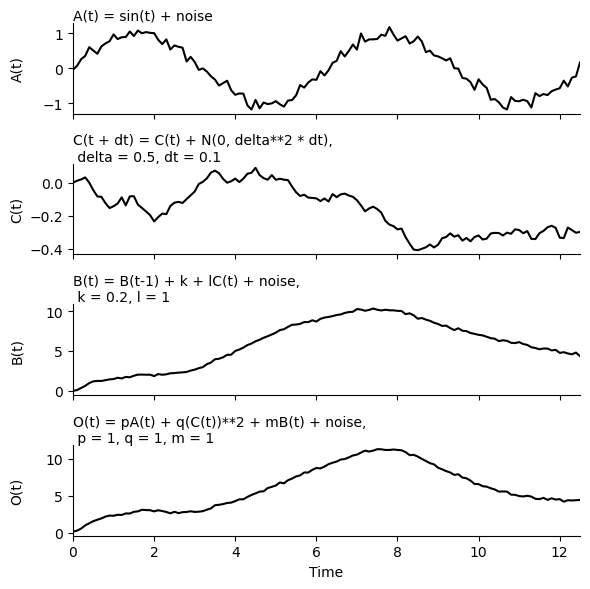

In [3]:
time = np.arange(0, 4*np.pi, 0.1)
model = FunctionalCausalModel(
    time,
    brownian_delta= 0.5,
    p = 1,
    q = 1,
    m = 1,
    k = 0.2,
    l = 1)
plot_model(model)

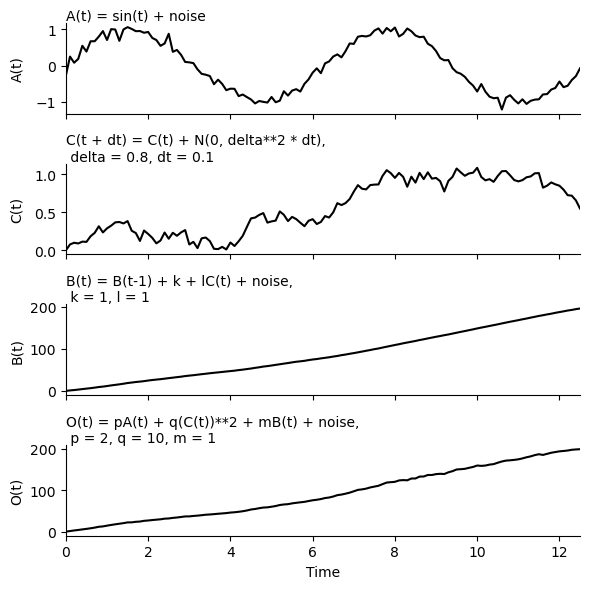

In [4]:
time = np.arange(0, 4*np.pi, 0.1)
model = FunctionalCausalModel(
    time,
    brownian_delta= 0.8,
    p = 2,
    q = 10,
    m = 1,
    k = 1,
    l = 1)
plot_model(model)